# Transfer Learning

In this notebook, we'll explore how you can use a pre-trained model to achieve good results even with a small training dataset. This is called _transfer learning_ and we do this by leveraging the trained layers of an existing model and adding your own layers to fit your application. For example, we can:

1. just get the convolution layers of one model
2. attach some dense layers onto it
3. train just the dense network
4. evaluate the results

Doing this will allow us to save time building our application because you will essentially skip weeks of training time of very deep networks. You will just use the features it has learned and tweak it for your dataset.

**IMPORTANT NOTE:** Best run on Google Colab

## Setting up the pretrained model

You will need to prepare pretrained model and configure the layers that you need. For this exercise, you will use the convolution layers of the [InceptionV3](https://arxiv.org/abs/1512.00567) architecture as your base model. To do that, you need to:

1. Set the input shape to fit your application. In this case. set it to `150x150x3` as you've been doing in the last few labs.

2. Pick and freeze the convolution layers to take advantage of the features it has learned already.

3. Add dense layers which you will train.


First, in preparing the input to the model, you want to fetch the pretrained weights of the `InceptionV3` model and remove the fully connected layer at the end because we'll be replacing it later. We'll also specify the input shape that your model will accept. Lastly, we want to freeze the weights of these layers because they have been trained already.

In [1]:
# Downloading the pre-trained weights. 
# No top- exclude the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-11-18 19:17:52--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   178MB/s    in 0.5s    

2022-11-18 19:17:52 (178 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Setting the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initializing the base model.
# Setting the input shape and removing the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Loading the pre-trained weights we downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freezing the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

We can see the summary of the model below. It's a very deep network. You can then select up to which point of the network you want to use - here we'll use up to `mixed_7` as our base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into your application. `mixed_7` on the other hand will be more generalized and you can start with that for your application.

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [4]:
# Choosing `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Adding dense layers for your classifier

Next, we add dense layers to your model. These will be the layers that you will train and is tasked with recognizing cats and dogs. You will add a Dropout layer as well to regularize the output and avoid overfitting.

In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flattening the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Adding a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Adding a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Adding a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Appending the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [6]:
# Setting the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

## Preparing the dataset

Now we'll prepare the dataset:

In [7]:
# Downloading the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2022-11-18 19:18:09--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   119MB/s    in 0.5s    

2022-11-18 19:18:09 (119 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extracting the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Defining our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Adding our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flowing training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flowing validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training the model

In [9]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 31s - loss: 0.3204 - accuracy: 0.8720 - val_loss: 0.1154 - val_accuracy: 0.9560 - 31s/epoch - 309ms/step
Epoch 2/20
100/100 - 20s - loss: 0.2215 - accuracy: 0.9170 - val_loss: 0.1621 - val_accuracy: 0.9410 - 20s/epoch - 198ms/step
Epoch 3/20
100/100 - 19s - loss: 0.2125 - accuracy: 0.9235 - val_loss: 0.1183 - val_accuracy: 0.9600 - 19s/epoch - 194ms/step
Epoch 4/20
100/100 - 20s - loss: 0.1712 - accuracy: 0.9285 - val_loss: 0.1158 - val_accuracy: 0.9630 - 20s/epoch - 197ms/step
Epoch 5/20
100/100 - 19s - loss: 0.1887 - accuracy: 0.9340 - val_loss: 0.3183 - val_accuracy: 0.9110 - 19s/epoch - 188ms/step
Epoch 6/20
100/100 - 19s - loss: 0.2026 - accuracy: 0.9330 - val_loss: 0.1234 - val_accuracy: 0.9580 - 19s/epoch - 187ms/step
Epoch 7/20
100/100 - 19s - loss: 0.1561 - accuracy: 0.9430 - val_loss: 0.1861 - val_accuracy: 0.9420 - 19s/epoch - 188ms/step
Epoch 8/20
100/100 - 21s - loss: 0.1815 - accuracy: 0.9365 - val_loss: 0.0972 - val_accuracy: 0.9650 - 21s/epoch - 212

## Evaluating the results

We can see the validation accuracy is also trending upwards as our training accuracy improves. This is a good sign that our model is not overfitting!

In [10]:
import matplotlib as mpl

In [11]:
mpl.rcParams['figure.figsize'] = (10,8)

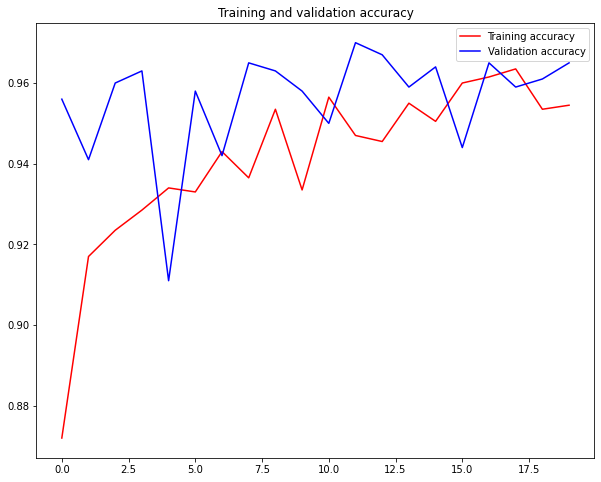

<Figure size 720x576 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

References:

[deeplearning.ai - TF](https://www.coursera.org/learn/convolutional-neural-networks-tensorflow/home/welcome)